# Survival Model for Non-Small Cell Lung Cancer
***
## Introduction

Lung cancer is the leading cause of cancer-related deaths worldwide, with an estimated 154,050 deaths in the US alone in 2018. I want to build a predictive model of one-year survival after diagnosis with NSCLC (non-small cell lung cancer) using both clinical and genomic data. Prognostic accuracy for life expectancy is highly valued by patients, their families, and healthcare professionals. It helps determine course of treatment and significantly aids end-of-life decision making.
<br/><br/>
The simulated dataset was provided by the US Department of Veteran Affairs. I will split the dataset into train, validation, and test sets. Cox proportional hazards regression with elastic net regularization will be used for my survival model. For model evaluation, I have chosen to use both concordance index and average partial log-likelihood.

### Data Description

The file clinical.csv contains clinical data on each patient. Its columns are as follows:
1.	ID: Unique identifier for the patient.
2.	Outcome: Whether the patient is alive or dead at the follow-up time.
3.	Survival.Months: The follow-up time in months.
4.	Age: The patient’s age in years at diagnosis.
5.	Primary.Site: Location of primary tumor.
6.	Histology: Tumor histology.
7.	Stage: Stage at diagnosis.
8.	Grade: Tumor grade.
9.	Num.Primaries: Number of primary tumors.
10.	Tumor.Size: Size of the tumor at diagnosis.
11.	T: Tumor Stage.
12.	N: Number of metastases to lymph nodes.
13.	M: Number of distant metastases.
14.	Radiation: Whether radiation took place (5) or not (0).
15.	Num.Mutations: The total number of mutations found in the tumor.
16.	Num.Mutated.Genes: The total number of genes with mutation.

The file genomics.csv contains information as to which genes were found to have a mutation in each patient’s tumor sequencing data. Only genes with a mutation are listed.
1.	ID: Unique identifier for the patient.
2.	Gene: The name of the gene.

## Data Wrangling

All necessary packages are imported, and display options and plotting styles are set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from lifelines import CoxPHFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines.calibration import survival_probability_calibration
from fancyimpute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import percentileofscore

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
pd.options.display.multi_sparse = False

In [3]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

<br/>The clinical data is imported as a pandas DataFrame.

In [4]:
df_c = pd.read_csv('clinical.csv', index_col=0)

In [5]:
df_c.head()

,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations
ID,,,,,,,,,,,,,,,
1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8
2,Dead,19.0,73,2,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,NaN,2,2
3,Dead,13.0,72,3,0,2,2.0,0.0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1
4,Dead,15.0,69,9,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,NaN,4,4
5,Dead,10.0,76,9,0,UNK,NaN,NaN,0,IIIA,Left Hilar,Large-cell carcinoma,NaN,3,3


The clinical DataFrame contains 190 rows (patients) and 15 columns (clinical characteristics). The target variables are Outcome (Survival status at follow-up) and Survival.Months (Follow-up time in months), while the remaining 13 columns are features for prediction.

In [6]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 1 to 190
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Outcome            190 non-null    object 
 1   Survival.Months    190 non-null    float64
 2   Age                190 non-null    int64  
 3   Grade              190 non-null    int64  
 4   Num.Primaries      190 non-null    int64  
 5   T                  190 non-null    object 
 6   N                  125 non-null    float64
 7   M                  94 non-null     float64
 8   Radiation          190 non-null    int64  
 9   Stage              190 non-null    object 
 10  Primary.Site       190 non-null    object 
 11  Histology          190 non-null    object 
 12  Tumor.Size         98 non-null     float64
 13  Num.Mutated.Genes  190 non-null    int64  
 14  Num.Mutations      190 non-null    int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 23.8+ KB


Several features contain missing values. N (# of metastases to lymph nodes), M (# of distant metastases) and Tumor.Size (Tumor size at diagnosis) all contain np.NaN values. Meanwhile, T (Tumor stage) contains 'UNK' values, and Grade (Tumor grade) contains 9's.<br/><br/>
There are 96 missing values in Grade, 62 in T, 65 in N, 96 in M, and 92 in Tumor.Size.<br/><br/>
Some features contain errors. Stage (Stage at diagnosis) contains the value '1B' which is meant to be 'IB', while Primary.Site (Location of primary tumor) contains the value 'Righ Upper Lobe' which is meant to be 'Right Upper Lobe'.

In [7]:
# Unique values of each column in df_c
for col in df_c:
    print(col + ':', sorted(df_c[col].unique()))

Outcome: ['Alive', 'Dead']
Survival.Months: [9.0, 9.5, 10.0, 11.0, 13.0, 15.0, 16.0, 18.0, 19.0, 22.0, 23.0, 24.0, 26.0, 29.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 46.0, 50.0, 71.0]
Age: [56, 59, 60, 62, 63, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 80, 82, 83, 84]
Grade: [2, 3, 4, 9]
Num.Primaries: [0, 1]
T: ['1', '1a', '1b', '2', '2a', '2b', '3', '4', 'UNK']
N: [0.0, 2.0, nan, 1.0, 3.0]
M: [nan, 0.0, 1.0]
Radiation: [0, 5]
Stage: ['1B', 'IA', 'IB', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IV', 'IVB']
Primary.Site: ['Both Lung', 'Left Hilar', 'Left Lower Lobe', 'Left Upper Lobe', 'Righ Upper Lobe', 'Right Hilar', 'Right Lower Lobe', 'Right Middle Lobe', 'Right Upper Lobe']
Histology: ['Adenocarcinoma', 'Large-cell carcinoma', 'Squamous cell carcinoma']
Tumor.Size: [1.4, nan, 1.0, 1.5, 1.6, 1.8, 1.9, 2.0, 2.5, 3.5, 3.6, 4.0, 4.4, 5.3, 5.4, 5.5, 8.0, 8.5, 9.0, 10.0]
Num.Mutated.Genes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Num.Mutations: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [8]:
# Values counts for each column in df_c
for col in df_c:
    print(df_c[col].value_counts())

Dead     150
Alive     40
Name: Outcome, dtype: int64
11.0    27
10.0    23
13.0    21
36.0    18
32.0    11
38.0     9
16.0     8
33.0     8
15.0     7
22.0     7
9.0      7
19.0     6
35.0     6
23.0     6
34.0     4
29.0     3
9.5      3
42.0     3
18.0     2
39.0     2
71.0     2
46.0     1
50.0     1
37.0     1
41.0     1
40.0     1
26.0     1
24.0     1
Name: Survival.Months, dtype: int64
62    27
76    26
67    22
72    20
71    14
73    13
69    13
70    10
63     8
82     7
74     7
56     5
83     4
68     4
77     4
80     2
78     1
60     1
59     1
84     1
Name: Age, dtype: int64
9    96
4    43
2    29
3    22
Name: Grade, dtype: int64
0    147
1     43
Name: Num.Primaries, dtype: int64
UNK    62
3      38
1a     26
4      23
2a     16
2      12
2b     10
1b      2
1       1
Name: T, dtype: int64
2.0    58
0.0    52
1.0     9
3.0     6
Name: N, dtype: int64
0.0    86
1.0     8
Name: M, dtype: int64
0    127
5     63
Name: Radiation, dtype: int64
IV      45
IIIA    43
IA

All missing values are changed to np.NaN, and the erroneous values are corrected. Also, for the binary variables Outcome and Radiation (whether the patient recieved radiation), I changed the values to [0, 1].

In [9]:
# Create a dictionary to find and replace values
dic_encode = {'Grade': {9: np.nan},
             'Radiation': {5: 1},
             'Stage': {'1B': 'IB'},
             'T': {'UNK': np.nan},
             'Primary.Site': {'Righ Upper Lobe': 'Right Upper Lobe'},
             'Outcome': {'Alive': 0, 'Dead': 1}
            }

df_c.replace(dic_encode, inplace=True)

Cancer stages range from 1 to 4, and each stage contains sub-stages of A and B. For the variables T and Stage, several values do not include sub-stages. For consistency purposes, I decided to remove the sub-stage information. I also changed the values of Stage to numerical values, because it is an ordinal variable and will allow me to test its correlation initially.

In [10]:
# Create a dictionary to find and replace values
dic_encode_2 = {'T': {'1': 1,'1a': 1,'1b': 1,'2': 2,'2a': 2,'2b': 2, '3': 3,'4': 4},
              'Stage': {'IA': 1,'IB': 1,'IIA': 2,'IIB': 2,'IIIA': 3,'IIIB': 3, 'IV': 4, 'IVB': 4}
             }

df_c.replace(dic_encode_2, inplace=True)

In [11]:
df_c.describe()

,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Tumor.Size,Num.Mutated.Genes,Num.Mutations
count,190.000000,190.000000,190.000000,94.000000,190.000000,128.000000,125.000000,94.000000,190.000000,190.000000,98.000000,190.000000,190.000000
mean,0.789474,22.186842,70.173684,3.148936,0.226316,2.429688,1.144000,0.085106,0.331579,2.910526,4.494898,2.684211,3.084211
std,0.408760,12.420140,6.146909,0.867048,0.419551,1.032416,1.029438,0.280536,0.472024,1.087395,3.050988,1.460327,1.697575
min,0.000000,9.000000,56.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,11.000000,67.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000
50%,1.000000,16.000000,71.000000,3.000000,0.000000,2.000000,2.000000,0.000000,0.000000,3.000000,3.600000,3.000000,3.000000
75%,1.000000,34.000000,74.000000,4.000000,0.000000,3.000000,2.000000,0.000000,1.000000,4.000000,8.000000,3.000000,4.000000
max,1.000000,71.000000,84.000000,4.000000,1.000000,4.000000,3.000000,1.000000,1.000000,4.000000,10.000000,8.000000,8.000000


After looking at both feature frequencies, I have decided to combine the values 'Right Middle Lobe' and 'Both Lung' within Primary.Site into a new value named 'Other'. The value 'Other' will have 8 positive occurences, which will pose less problems when splitting the dataset into train and test sets.

In [12]:
# Create a dictionary to find and replace values
dic_encode_3 = {'Primary.Site': {'Right Middle Lobe': 'Other','Both Lung': 'Other'}}

df_c.replace(dic_encode_3, inplace=True)

The genomic data is now imported as a pandas DataFrame.

In [13]:
df_g = pd.read_csv('genomics.csv', index_col=0)

In [14]:
df_g.head()

,Gene
ID,
1,AKT1
158,AKT1
88,ALK_Col1
132,ALK_Col1
18,ALK_Col2


The genomic DataFrame has 510 rows and one column, but it needs to be changed to have the same structure as the clinical DataFrame.

In [15]:
df_g.shape

(510, 1)

I now change the genomic DataFrame so that each patient's ID is only listed once on the index, while the names of the genes are the column labels. The values of the restructured DataFrame are 1's and 0's indicating whether or not a patient has a mutation of a given gene.

In [16]:
df_g['Value'] = 1
df_g = df_g.pivot_table(index='ID', columns='Gene', aggfunc=lambda x: int(x.any()), fill_value=0)
df_g.columns = df_g.columns.droplevel()
df_g.columns.name = None

In [17]:
df_g.head()

,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


The gemomic DataFrame contains 184 rows (patients) and 50 columns (genes). Not all 190 patients from the clinical dataset are included, because the clinical dataset listed 6 patients as having no gene mutations.

In [18]:
df_g.shape

(184, 50)

In [19]:
# The unique values in all of df_g
print(pd.unique(df_g.values.ravel()))

[1 0]


In [20]:
# The frequency of each gene mutation
freq_g = df_g.sum().sort_values(ascending=False)
freq_g.name = 'Frequency'
freq_g

TP53_Col1    117
KRAS_Col1     55
CDKN2A        45
TSC2          31
MSH2          30
STK11         23
APC           19
PIK3CB        11
NF_Col2       10
TERT          10
SMARCB1        9
MET            9
SMO            8
FBXW7          8
TP53_Col2      8
GNAS           7
MSH6           7
NF_Col3        7
PTEN           7
NTRK1          7
PIK3CA         7
EGFR           6
NF_Col1        5
PDGFRB         5
POLD_Col2      5
FGFR1          4
CTNNB1         4
RB1            4
PTCH1          4
ATM_Col1       4
NOTCH1         4
DNMT3A         3
CCND2          2
ALK_Col2       2
ALK_Col1       2
ERBB4          2
AKT1           2
FGFR3          2
FLT4           2
FOXL2          2
NF_Col5        2
ERBB3          1
ESR1           1
HNF1A          1
BRAF           1
ATM_Col2       1
KRAS_Col2      1
MLH_Col2       1
SMARCA4        1
MAP2K2         1
Name: Frequency, dtype: int64

Now the clinical and genomic DataFrames are combined horizontally into one.

In [21]:
df = df_c.join(df_g, how='outer')

In [22]:
df.head()

,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,9.0,67,4.0,0,NaN,2.0,NaN,0,4,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1,19.0,73,2.0,0,NaN,2.0,0.0,1,4,Right Upper Lobe,Adenocarcinoma,NaN,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,13.0,72,3.0,0,2.0,2.0,0.0,0,3,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,15.0,69,NaN,1,1.0,0.0,1.0,0,1,Right Upper Lobe,Adenocarcinoma,NaN,4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1,10.0,76,NaN,0,NaN,NaN,NaN,0,3,Left Hilar,Large-cell carcinoma,NaN,3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


The np.NaN values of the 6 patients with no genetic mutations are filled with zeros.

In [23]:
df.loc[:,'AKT1':] = df.loc[:,'AKT1':].fillna(0)

The full dataset now has 190 rows (patients) and 65 columns (clinical and genomic characteristics).

In [24]:
df.shape

(190, 65)

There are missing values in the following columns:

In [25]:
missing_cols = df.columns[df.isna().any()].tolist()
missing_cols

['Grade', 'T', 'N', 'M', 'Tumor.Size']

## Data Storytelling and Statistical Methods

The following charts show the surival time distributions of each distinct value of the 5 categorical and ordinal features (missing values are ignored). The plots also indicate whether patients are dead or alive at follow-up.

In [26]:
def surv_graph(df, var, var_title, rows, cols, fig_x, fig_y, leg_x, leg_y, ti_x, ti_y):
    cats = sorted(df[var].unique(), reverse=True)
    if isinstance(cats[0], float):
        cats = [int(x) for x in cats if str(x) != 'nan']
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_x, fig_y))
    a = axs.ravel()
    for i, ax in enumerate(a):
        if i < len(cats):
            data = df[df[var] == cats[i]]
            x = data[data.Outcome == 1]['Survival.Months']
            y = data[data.Outcome == 0]['Survival.Months']
            ax.hist([x, y], bins=np.arange(8, 72, 8), stacked=True, color=['b', 'g'], label=['Dead', 'Alive'])
            ax.set_title(cats[i])
            handles, labels = ax.get_legend_handles_labels()
        ax.set_xlim(8, 72)
        ax.set_ylim(0, 45)
        ax.set(xlabel='Survival Time', ylabel='# of Patients')
        ax.label_outer()
    fig.legend(handles, labels, bbox_to_anchor=(leg_x, leg_y, 0.5, 0.5))
    fig.suptitle('Survival Time Distribution by ' + var_title, fontsize=16, x=ti_x, y=ti_y)
    plt.tight_layout()

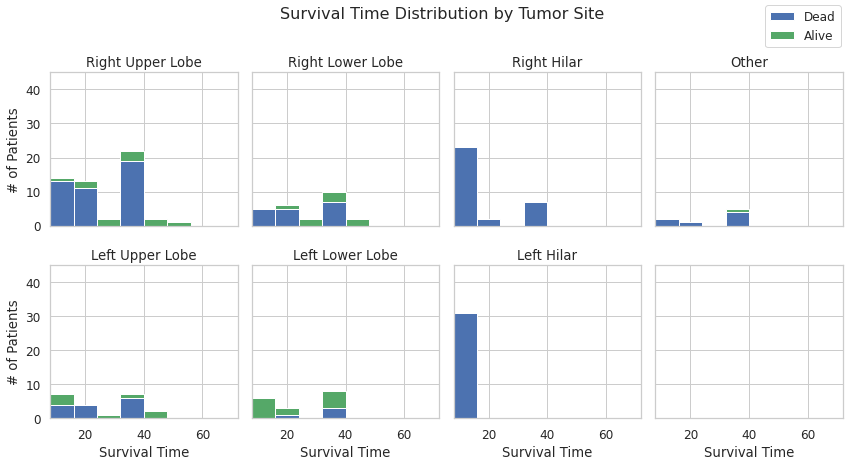

In [27]:
surv_graph(df_c, 'Primary.Site', 'Tumor Site', 2, 4, 12, 6, 0.48, 0.58, 0.52, 1.08)

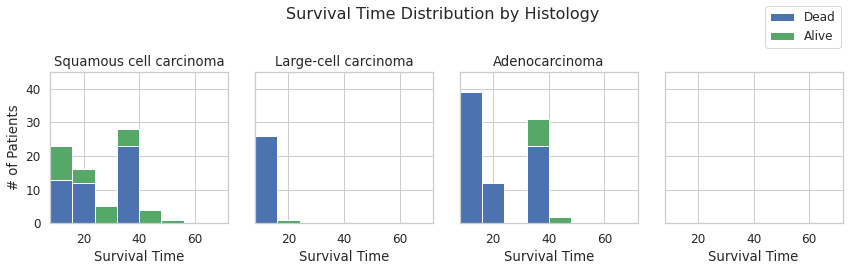

In [28]:
surv_graph(df_c, 'Histology', 'Histology', 1, 4, 12, 3.3, 0.48, 0.64, 0.52, 1.14)

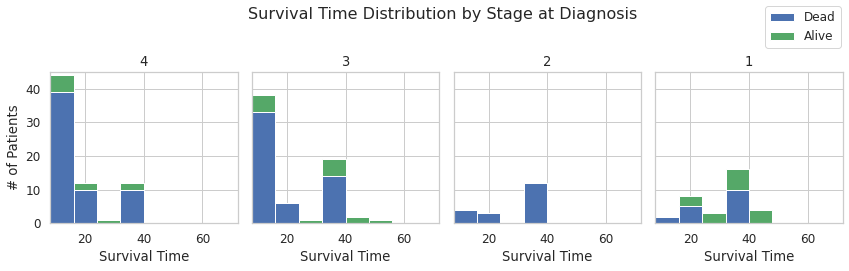

In [29]:
surv_graph(df_c, 'Stage', 'Stage at Diagnosis', 1, 4, 12, 3.3, 0.48, 0.64, 0.52, 1.14)

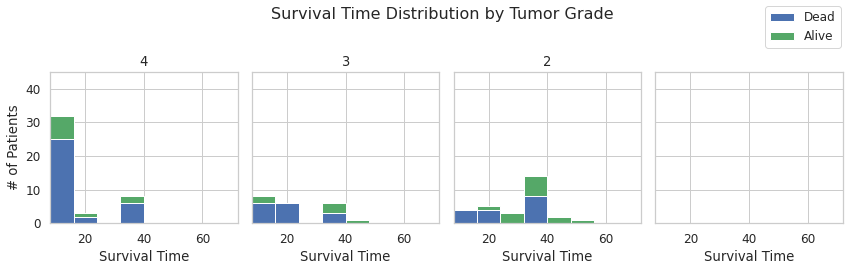

In [30]:
surv_graph(df_c, 'Grade', 'Tumor Grade', 1, 4, 12, 3.3, 0.48, 0.64, 0.52, 1.14)

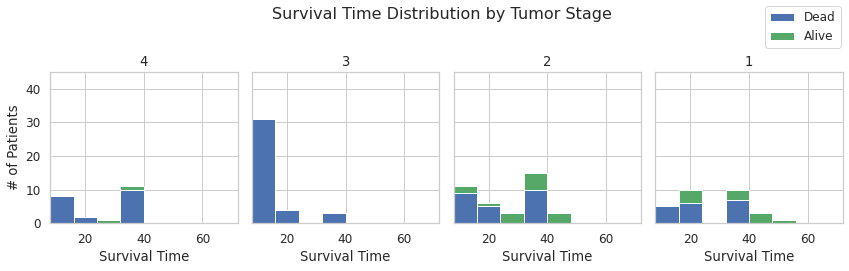

In [31]:
surv_graph(df_c, 'T', 'Tumor Stage', 1, 4, 12, 3.3, 0.48, 0.64, 0.52, 1.14)

From these plots, it is evident that large-cell carcinoma histology and right and left hilar primary tumor site are associated with reduced survival time, while squamous cell carcinoma histology is associated with longer survival. As expected, there is also a clear trend where survival time decreases as tumor stage and grade increase.

<br/><br/>
Here is the correlation matrix heatmap of the clinical data with missing values. I changed the categorical features Primary.Site and Histology (Tumor histology) into dummy variables before creating it so that their correlations would also show.

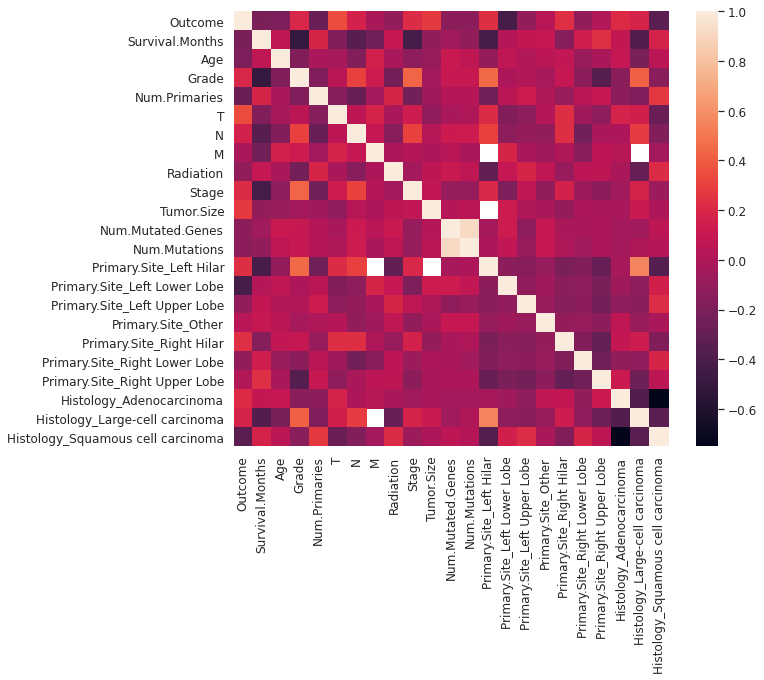

In [32]:
corrmat = pd.get_dummies(df_c).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrmat, square=True);

In [33]:
# Funtion to create a sorted correlation series
# Correlations between subsets of features are not returned if specified
def corr_series(corrmat, col1_start=False, col1_end=False, col2_start=False, col2_end=False):
    cs = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))
    if col1_start and col1_end:
        cs.loc[col1_start:col1_end, col1_start:col1_end] = np.nan
    if col2_start and col2_end:
        cs.loc[col2_start:col2_end, col2_start:col2_end] = np.nan
    return cs.stack().sort_values(ascending=False)

Here is the only clinical feature that is positively correlated with death (r > 0.3).

In [34]:
outlook_corr_c = corrmat['Outcome'].drop('Outcome').sort_values(ascending=False)
outlook_corr_c[outlook_corr_c > .3]

T    0.346382
Name: Outcome, dtype: float64

These are the clinical features that are negatively correlated with death (r < -0.3).

In [35]:
outlook_corr_c[outlook_corr_c < -.3].sort_values()

Primary.Site_Left Lower Lobe        -0.426118
Histology_Squamous cell carcinoma   -0.336315
Name: Outcome, dtype: float64

And these are the clinical features that are negatively correlated with survival time (r < -0.3). Surival time is not positively correlated with any of the clinical features.

In [36]:
months_corr_c = corrmat['Survival.Months'].drop('Survival.Months').sort_values(ascending=False)
months_corr_c[months_corr_c < -.3].sort_values()

Grade                            -0.498487
Stage                            -0.427541
Primary.Site_Left Hilar          -0.416006
Histology_Large-cell carcinoma   -0.373633
N                                -0.346523
Name: Survival.Months, dtype: float64

These are the clinical features that are postively correlated with each other (r > 0.3).

In [37]:
cs = corr_series(corrmat.iloc[2:, 2:], 'Primary.Site_Left Hilar', 'Primary.Site_Right Upper Lobe', 'Histology_Adenocarcinoma',
                 'Histology_Squamous cell carcinoma')
cs[cs > .3]

Num.Mutated.Genes        Num.Mutations                     0.915735
Primary.Site_Left Hilar  Histology_Large-cell carcinoma    0.554587
Grade                    Primary.Site_Left Hilar           0.446945
Grade                    Stage                             0.430301
Grade                    Histology_Large-cell carcinoma    0.412820
N                        Stage                             0.310238
N                        Primary.Site_Left Hilar           0.308295
dtype: float64

And these are the clinical features that are negatively correlated with each other (r < -0.3).

In [38]:
cs[cs < -.3].sort_values()

Primary.Site_Left Hilar  Histology_Squamous cell carcinoma   -0.364492
Grade                    Primary.Site_Right Upper Lobe       -0.354973
Radiation                Primary.Site_Left Hilar             -0.310993
dtype: float64

Unsurprisingly, the strongest positive correlation is between Num.Mutated.Genes (# of genes with mutation) and Num.Mutations (# of mutations in the tumor).<br/><br/>
Tumor stage is the only clinical feature that is positively correlated with death. Meanwhile, tumor grade, stage at diagnosis, left hilar primary site, large cell carcinoma histology, and number of mestastases to lymph nodes are each negatively correlated with survival time. Many of these clinical features are also positively correlated with each other.<br/><br/>
Left lower lobe primary site and squamous cell carcinoma histology are both negatively correlated with death, while none of the clinical features are positively correlated with survival time. Squamous cell carcinoma histology is also negatively correlated with left hilar primary site, which itself has a negative correlation with survival time.

<br/>
Here is the correlation matrix of the entire dataset. Once again, I changed the categorical features Primary.Site and Histology into dummy variables before creating the matrix so that their correlations would show.

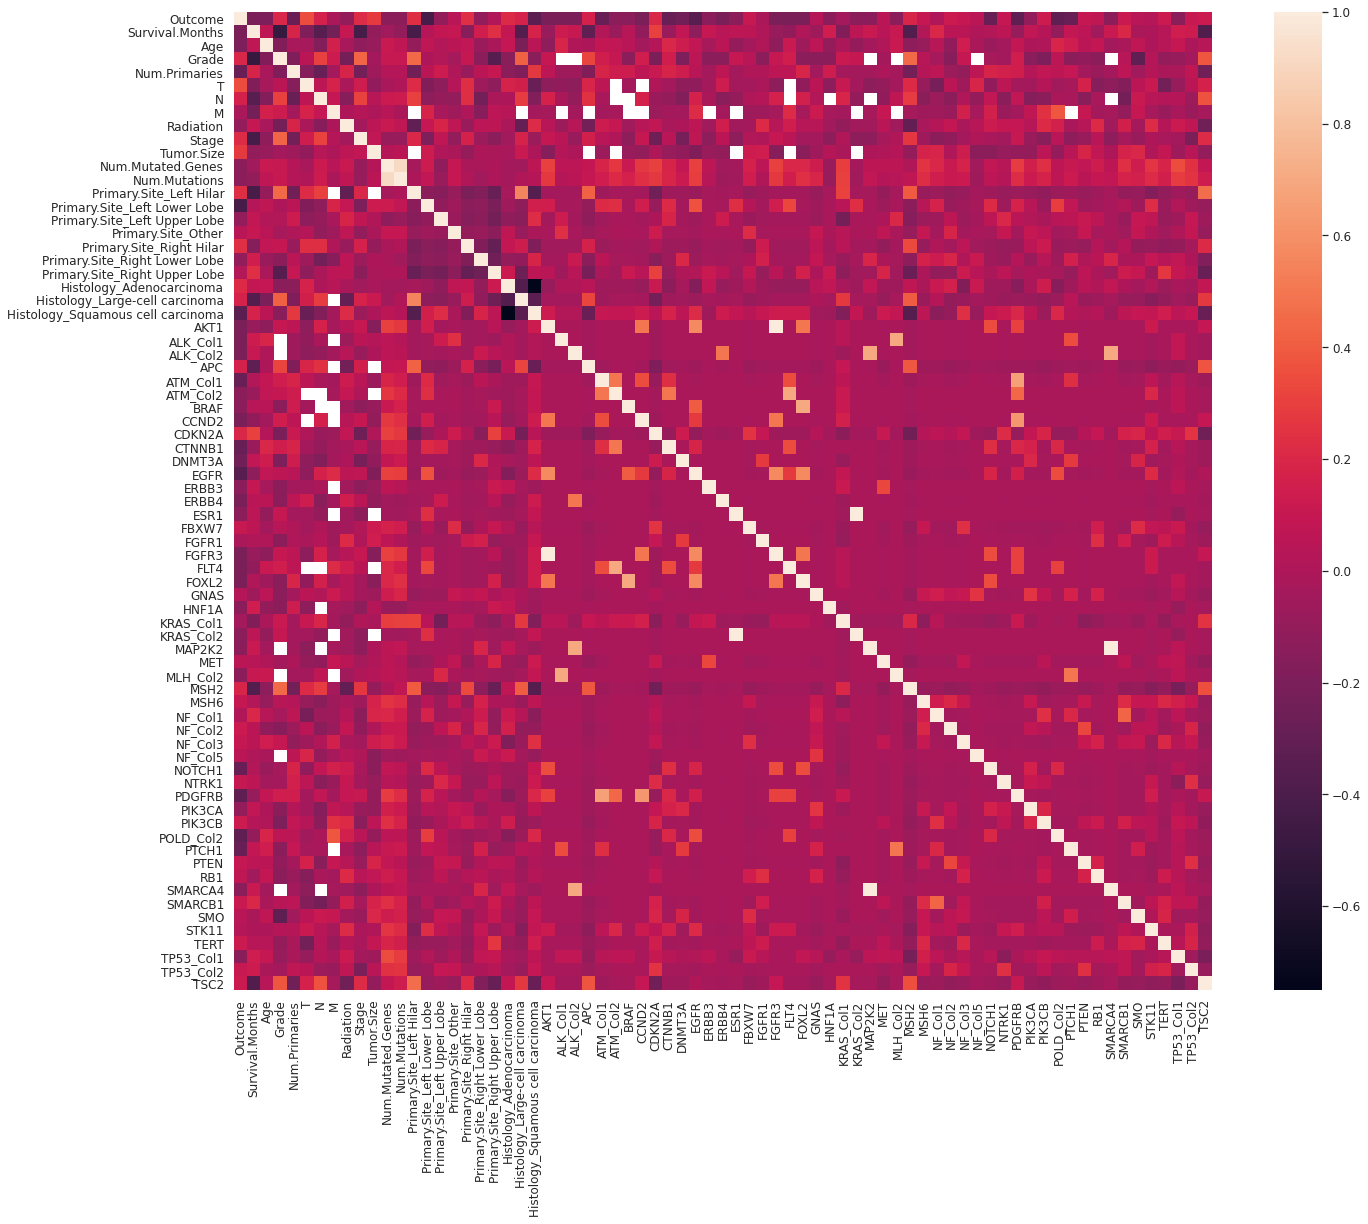

In [39]:
df_c_dumb = pd.get_dummies(df_c)
df_corr = df_c_dumb.join(df_g, how='outer')
df_corr.loc[:,'AKT1':] = df_corr.loc[:,'AKT1':].fillna(0)
corrmat_full = df_corr.corr()
plt.figure(figsize=(22, 18))
sns.heatmap(corrmat_full, square=True);

These are the genomic features that are negatively correlated with survival time (r < 0.3). The frequency of each genetic mutation is also included. Survival time is not positively correlated with any of the genomic features.

In [40]:
months_corr_g = pd.concat([corrmat_full['Survival.Months'].loc['AKT1':].sort_values(ascending=False), freq_g], axis=1)
months_corr_g.columns = ['Correlation', 'Frequency']
months_corr_g[months_corr_g.Correlation <= -.3].sort_values('Correlation')

,Correlation,Frequency
TSC2,-0.383810,31
MSH2,-0.378229,30
APC,-0.313774,19


And these are the genomic features that are negatively correlated with death (r <= -0.3). Death is not positively correlated with any of the genomic features.

In [41]:
outcome_corr_g = pd.concat([corrmat_full['Outcome'].loc['AKT1':].sort_values(ascending=False), freq_g], axis=1)
outcome_corr_g.columns = ['Correlation', 'Frequency']
outcome_corr_g[outcome_corr_g.Correlation <= -.3].sort_values('Correlation')

,Correlation,Frequency
EGFR,-0.349689,6
POLD_Col2,-0.318357,5
PDGFRB,-0.318357,5


These are the genomic features that are positively correlated with clinical features (r > 0.3).

In [42]:
cs_full = corr_series(corrmat_full.iloc[2:, 2:], 'Age', 'Histology_Squamous cell carcinoma', 'AKT1', 'TSC2')

corr_pos = cs_full[cs_full >= .3].reset_index().join(freq_g, on='level_1', how='left').set_index(['level_0', 'level_1'])
corr_pos.columns = ['Correlation', 'Frequency']
corr_pos.index.names = (None, None)
corr_pos

,,Correlation,Frequency
Primary.Site_Left Hilar,TSC2,0.460337,31
Grade,MSH2,0.446945,30
Primary.Site_Left Hilar,APC,0.422561,19
Histology_Large-cell carcinoma,MSH2,0.402509,30
Primary.Site_Left Hilar,MSH2,0.394731,30
Grade,TSC2,0.381300,31
M,POLD_Col2,0.378415,5
Primary.Site_Left Lower Lobe,EGFR,0.365169,6
N,TSC2,0.364366,31
Num.Mutated.Genes,TP53_Col1,0.348781,117


And these are the genomic features that are negatively correlated with clinical features (r < -0.3).

In [43]:
corr_neg = cs_full[cs_full < -.3].reset_index().join(freq_g, on='level_1', how='left').set_index(['level_0', 'level_1'])
corr_neg.columns = ['Correlation', 'Frequency']
corr_neg.index.names = (None, None)
corr_neg.sort_values('Correlation')

,,Correlation,Frequency
Histology_Squamous cell carcinoma,MSH2,-0.357443,30
Grade,SMO,-0.315766,8
Radiation,MSH2,-0.304978,30


Mutations of TSC2, MSH2, and APC are each negatively correlated with survival time, while no genetic mutations are positively correlated with death. These mutations also each have positive correlations with many of the clinical features that are negatively correlated with survival time. Also, a mutation of MSH2 is negatively correlated with Squamous cell carcinoma histology, which itself has a negative correlation with death.

Mutations of EGFR, POLD_Col2, and PDGFRB are each negatively correlated with death, while no genetic mutations are positively correlated with survival time. A mutation of EGFR is also positively correlated with left lower lobe primary site, which itself has a negative correlation with death.
<br/><br/><br/>